In [2]:
from time import time
import numpy, os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2

#Path to the root image directory containing sub-directories of images
path="dataset/"

data_slice = [70,195,78,172] # [ ymin, ymax, xmin, xmax]
# to extract the ‘interesting’ part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimention
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

n_sample = 0 #Initial sample count
label_count = 0 #Initial label count
n_classes = 0 #Initial class count

#PCA Component 
n_components = 7

Image dimension after resize (h,w) : 50 37


In [3]:
#Flat image Feature Vector
X=[]
#Int array of Label Vector
Y=[]

target_names = [] #Array to store the names of the persons

for directory in os.listdir(path):
    for file in os.listdir(path+directory):
        img=cv2.imread(path+directory+"/"+file)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        img=cv2.resize(img, (w,h))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        featurevector=numpy.array(img).flatten()
        X.append(featurevector)
        Y.append(label_count)
        n_sample = n_sample + 1
    target_names.append(directory)
    label_count=label_count+1


print("Samples :", n_sample)
print("Class :", target_names)
n_classes = len(target_names)

Samples : 80
Class : ['Dede', 'Odi', 'Tiger_Woods', 'Yunus']


In [5]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and teststing set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, len(X_train)))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("\n")
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 7 eigenfaces from 60 faces
done in 0.385s


Projecting the input data on the eigenfaces orthonormal basis
done in 0.005s


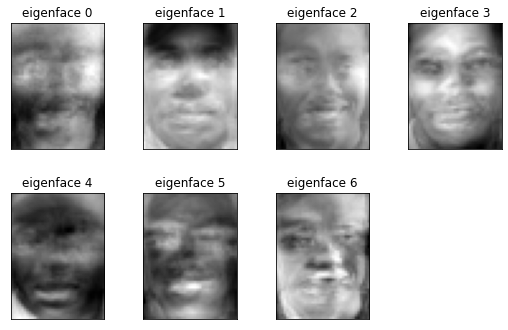

In [6]:
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_components):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [7]:
###############################################################################
# Train a SVM classification model
print("\n")
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

print("\n")
print("Best estimator found by grid search : ")
print(clf.best_estimator_)

###############################################################################
# Quantitative evaluation of the model quality on the test set
print("\n")
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca,y_test))
print("done in %0.3fs" % (time() - t0))

print("\nClassification Report : ")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))




Fitting the classifier to the training set
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ............C=1000.0, gamma=0.0001;, score=0.917 total time=   0.0s
[CV 2/5] END ............C=1000.0, gamma=0.0001;, score=0.917 total time=   0.0s
[CV 3/5] END ............C=1000.0, gamma=0.0001;, score=1.000 total time=   0.0s
[CV 4/5] END ............C=1000.0, gamma=0.0001;, score=0.917 total time=   0.0s
[CV 5/5] END ............C=1000.0, gamma=0.0001;, score=0.917 total time=   0.0s
[CV 1/5] END ............C=1000.0, gamma=0.0005;, score=0.833 total time=   0.0s
[CV 2/5] END ............C=1000.0, gamma=0.0005;, score=0.917 total time=   0.0s
[CV 3/5] END ............C=1000.0, gamma=0.0005;, score=1.000 total time=   0.0s
[CV 4/5] END ............C=1000.0, gamma=0.0005;, score=0.917 total time=   0.0s
[CV 5/5] END ............C=1000.0, gamma=0.0005;, score=1.000 total time=   0.0s
[CV 1/5] END .............C=1000.0, gamma=0.001;, score=0.833 total time=   0.0s
[C

In [8]:
###############################################################################
# Prediction of user based on the model

test = []
#testImage = "test/Tiger_Woods_0010.jpg"
testImage = "test/Odi-1.jpg"


testImage=cv2.imread(testImage)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
testImage=cv2.resize(testImage, (w,h))
testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
testImageFeatureVector=numpy.array(testImage).flatten()
test.append(testImageFeatureVector)
testImagePCA = pca.transform(test)
testImagePredict=clf.predict(testImagePCA)


print ("Predicted Name : " + target_names[testImagePredict[0]])


Predicted Name : Odi


In [9]:
path_testdata = "test/"
for file in os.listdir(path_testdata):
    test = []

    filename=path_testdata + file    
    testImage=cv2.imread(filename)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
    testImage=cv2.resize(testImage, (w,h))
    testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
    testImageFeatureVector=numpy.array(testImage).flatten()
    
    test.append(testImageFeatureVector)
    testImagePCA = pca.transform(test)
    testImagePredict=clf.predict(testImagePCA)

    print ("File Source : " + filename)
    print ("Predicted Name : " + target_names[testImagePredict[0]] + "\n")

File Source : test/Dede-1.jpg
Predicted Name : Dede

File Source : test/Dede-2.jpg
Predicted Name : Dede

File Source : test/Dede-3.jpg
Predicted Name : Dede

File Source : test/Dede-4.jpg
Predicted Name : Dede

File Source : test/George_W_Bush_0037.jpg
Predicted Name : Tiger_Woods

File Source : test/George_W_Bush_0526.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0021.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0022.jpg
Predicted Name : Yunus

File Source : test/Megawati_Sukarnoputri_0023.jpg
Predicted Name : Yunus

File Source : test/Megawati_Sukarnoputri_0024.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0025.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0026.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0027.jpg
Predicted Name : Yunus

File Source : test/Megawati_Sukarnoputri_0028.jpg
Predicted Name : Yunus

File Source : test/Megawati_

In [18]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

cap.set(3,640)
cap.set(4,480)

while(True):
    # Capture frame-by-frame
    test = []
    face = []
    ret, frame = cap.read()
    xv, yv, cv = frame.shape
    if ret == True :
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,wf,hf) in faces:
            cy, cx = y + (hf//2), x + (wf//2)
            max_len = max(max(hf//2,wf//2), 125)
            
            if (x - max_len) <= 0 or (x + max_len) >= xv or (y - max_len) <= 0 or (y + max_len) >= yv :
                continue
            face_crop = (frame[cy-max_len:cy+max_len, cx-max_len:cx+max_len])
            face_crop = face_crop[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
            
            testImage = cv2.resize(face_crop, (w,h))
            cv2.imshow('face',testImage)
            
            testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
            testImageFeatureVector=numpy.array(testImage).flatten()
            test.append(testImageFeatureVector)
            testImagePCA = pca.transform(test)
            testImagePredict=clf.predict(testImagePCA)
            
            # create box on detected face
            frame = cv2.rectangle(frame,(x,y),(x+wf,y+hf),(255,0,0),1)
            frame = cv2.rectangle(frame,(x,y+hf),(x+wf,y+hf+30),(255,0,0),-1)
            # print label name on image
            cv2.putText(frame, "Name : " + target_names[testImagePredict[0]], (x + x//10, y+hf+20), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        cv2.imshow('frame',frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
250*250

In [ ]:
print([data_slice[0]-data_slice[1], data_slice[2]-data_slice[3]])

In [ ]:
125*94

In [ ]:
hf,wf = 21,20
(max(hf,wf)*1.25)//2

# Naive Bayes

In [1]:
import os
import numpy as np
from skimage.filters import threshold_otsu
import cv2

letters = [
           '0','1','2','3','4','5','6','7','8','9','A','B','C','D',
           'E','F','G','H','J','K','L','M','N','P','Q','R','S','T',
           'U','V','W','X','Y','Z'
            ]
training_directory = './train20X20'

image_data = []
target_data = []

for each_letter in letters:
    for each in range(10):
        image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
        img_details = cv2.imread(image_path)
        gray_image = cv2.cvtColor(img_details, cv2.COLOR_BGR2GRAY)
        threshold_value = threshold_otsu(gray_image)
        binary_image = gray_image > threshold_value
        binary_image = binary_image * 255
        binary_image = binary_image.astype(np.uint8)
        
        #Reshape in to 1D array
        flat_bin_image = binary_image.reshape(-1)
        image_data.append(flat_bin_image)
        target_data.append(each_letter)

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

num_of_fold = 4

# this uses the concept of cross validation to measure the accuracy
# of a model, the num_of_fold determines the type of validation
# e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
# and the remaining 3/4 for the training

accuracy_result = cross_val_score(gnb_model, image_data, target_data, cv=num_of_fold)
print("Cross Validation Result for ", str(num_of_fold), " -fold")
print (accuracy_result * 100)

Cross Validation Result for  4  -fold
[91.76470588 89.41176471 90.58823529 95.29411765]


In [3]:
import pickle

#Generate GNB Model from image_data array and data label
gnb_model.fit(image_data, target_data)

#save gegnerated model into (.sav)
print("model trained.saving model..")
filename = './gnb_finalized_model.sav'
pickle.dump(gnb_model, open(filename, 'wb'), protocol=2)
print("model saved")

model trained.saving model..
model saved


In [1]:
import cv2
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
import numpy as np
import pickle

img = cv2.imread ('geliga.jpeg') #read image

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale level image

threshold_value = threshold_otsu(gray_image) #search threshold value using otsu method
binary_image = gray_image > threshold_value #generate new array (true: value > threshold)
binary_image = binary_image * 255 # scale boolean value to 0 or 255
binary_image = binary_image.astype(np.uint8) # convert array to uint8 (8bit value per pixel)
binary_image = 255 - binary_image

# invert color (black white)
# binary_image = np.invert(binary_image)

#close connected region if distance less than 3 pixel
binary_image = closing(binary_image, square(3))

#remove artifacts connected to image border
binary_image = clear_border(binary_image)

label_img = label(binary_image)
regionprops_img = regionprops(label_img)

for region in regionprops_img:
    y0, x0, y1, x1 = region.bbox

characters= []
column_list = []
last_y0 = 0

regionprops_img = regionprops(label_img)

for region in regionprops_img:
    y0, x0, y1, x1 = region.bbox
    
    cv2.rectangle(img, (x0, y0), (x1, y1), (0,0, 255),1)
    
    roi = binary_image[y0:y1, x0:x1]
    
    resized_char = cv2.resize(roi, (20, 20))
    
    characters.append(resized_char)
    column_list.append(x0)
    
print("load data finish!")

load data finish!


In [2]:
#load saved GNB Model
filename = './gnb_finalized_model.sav'
model = pickle.load(open(filename, 'rb'))

classification_result = []

for each_character in characters:
    
    #converts it to a 1D Array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)
    
print('Classification Result : ')
print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]
    
print("\n")
print('Predicted Character : ')
print(plate_string)

cv2.imshow("Original Image", img)
cv2.imshow("Binary Image", binary_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

print("Finish")

Classification Result : 
[array(['D'], dtype='<U1'), array(['L'], dtype='<U1'), array(['1'], dtype='<U1'), array(['N'], dtype='<U1'), array(['1'], dtype='<U1'), array(['1'], dtype='<U1'), array(['D'], dtype='<U1'), array(['L'], dtype='<U1'), array(['1'], dtype='<U1'), array(['1'], dtype='<U1'), array(['1'], dtype='<U1')]


Predicted Character : 
DL1N11DL111


In [ ]:
#KNN

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting and visualozing data

#read data to pandas dataframe
#our dataset
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
5,2,mandarin,mandarin,80,5.8,4.3,0.77
6,2,mandarin,mandarin,80,5.9,4.3,0.81
7,2,mandarin,mandarin,76,5.8,4.0,0.81
8,1,apple,braeburn,178,7.1,7.8,0.92
9,1,apple,braeburn,172,7.4,7.0,0.89


In [30]:
fruits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_label    59 non-null     int64  
 1   fruit_name     59 non-null     object 
 2   fruit_subtype  59 non-null     object 
 3   mass           59 non-null     int64  
 4   width          59 non-null     float64
 5   height         59 non-null     float64
 6   color_score    59 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.4+ KB


In [31]:
# create a mapping from fruit label value to fruit name to make results easier to interpret
predct = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))   
predct

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

In [32]:
#checking how many unique fruit names are present in the dataset
fruits['fruit_name'].value_counts()

orange      19
apple       19
lemon       16
mandarin     5
Name: fruit_name, dtype: int64

In [33]:
apple_data=fruits[fruits['fruit_name']=='apple']

orange_data=fruits[fruits['fruit_name']=='orange']

lemon_data=fruits[fruits['fruit_name']=='lemon']

mandarin_data=fruits[fruits['fruit_name']=='mandarin']

In [20]:
apple_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
8,1,apple,braeburn,178,7.1,7.8,0.92
9,1,apple,braeburn,172,7.4,7.0,0.89


In [21]:
mandarin_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
5,2,mandarin,mandarin,80,5.8,4.3,0.77
6,2,mandarin,mandarin,80,5.9,4.3,0.81
7,2,mandarin,mandarin,76,5.8,4.0,0.81


In [22]:
orange_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
24,3,orange,spanish_jumbo,342,9.0,9.4,0.75
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
26,3,orange,spanish_jumbo,362,9.6,9.2,0.74
27,3,orange,selected_seconds,204,7.5,9.2,0.77
28,3,orange,selected_seconds,140,6.7,7.1,0.72


In [23]:
lemon_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
43,4,lemon,spanish_belsan,194,7.2,10.3,0.70
44,4,lemon,spanish_belsan,200,7.3,10.5,0.72
45,4,lemon,spanish_belsan,186,7.2,9.2,0.72
46,4,lemon,spanish_belsan,216,7.3,10.2,0.71
47,4,lemon,spanish_belsan,196,7.3,9.7,0.72


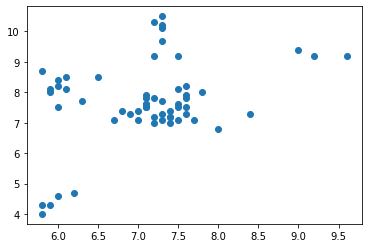

In [24]:
plt.scatter(fruits['width'],fruits['height'])

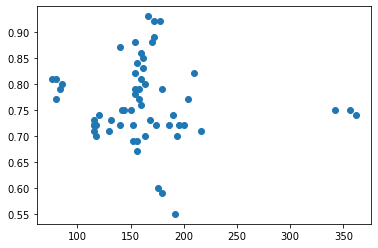

In [25]:
plt.scatter(fruits['mass'],fruits['color_score'])

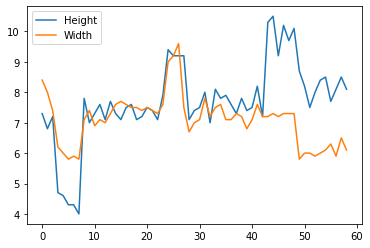

In [26]:
plt.plot(fruits['height'],label='Height')
plt.plot(fruits['width'],label='Width')
plt.legend()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X=fruits[['mass','width','height']]
Y=fruits['fruit_label']
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=0)

In [30]:
X_train.describe()

,mass,width,height
count,44.000000,44.000000,44.000000
mean,159.090909,7.038636,7.643182
std,53.316876,0.835886,1.370350
min,76.000000,5.800000,4.000000
25%,127.500000,6.175000,7.200000
50%,157.000000,7.200000,7.600000
75%,172.500000,7.500000,8.250000
max,356.000000,9.200000,10.500000


In [31]:
X_test.describe()

,mass,width,height
count,15.000000,15.00000,15.000000
mean,174.933333,7.30000,7.840000
std,60.075508,0.75119,1.369463
min,84.000000,6.00000,4.600000
25%,146.000000,7.10000,7.250000
50%,166.000000,7.20000,7.600000
75%,185.000000,7.45000,8.150000
max,362.000000,9.60000,10.300000


In [33]:
knn=KNeighborsClassifier()

In [34]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [35]:
knn.score(X_test,y_test)

0.5333333333333333

In [39]:
#parameters of following function are mass,width and height
#contoh 1
prediction1=knn.predict([[100, 6.3, 8]])
predct[prediction1[0]]

C:\Users\dedeg\.conda\envs\PCD\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


'lemon'

In [40]:
#contoh 2
prediction2=knn.predict([[300, 7, 10]])
predct[prediction2[0]]

C:\Users\dedeg\.conda\envs\PCD\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


'orange'